C:\Users\thais\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\thais\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


== Class weights for loss: bg=1.00, fg=7.42
Epoch 1/10: loss=0.7312
Epoch 2/10: loss=0.6618
Epoch 3/10: loss=0.7073
Epoch 4/10: loss=0.6406
Epoch 5/10: loss=0.6879
Epoch 6/10: loss=0.6763
Epoch 7/10: loss=0.6101
Epoch 8/10: loss=0.6380
Epoch 9/10: loss=0.6797
Epoch 10/10: loss=0.6226
Training Done!

== Visualize kết quả trên ảnh TRAIN ==


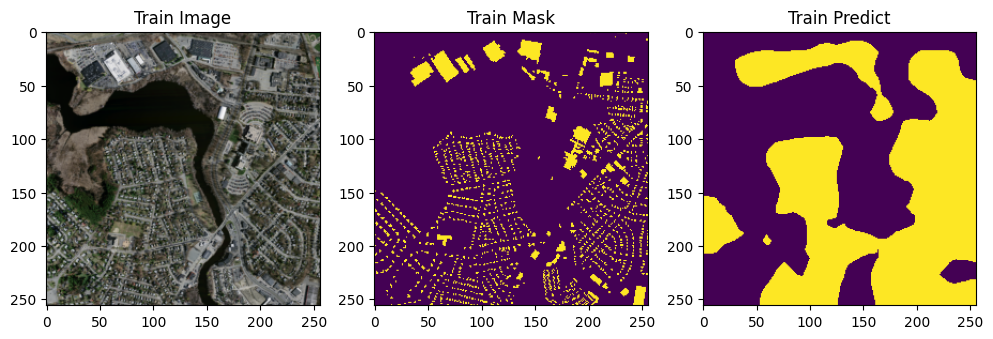


== Visualize kết quả trên ảnh VAL ==


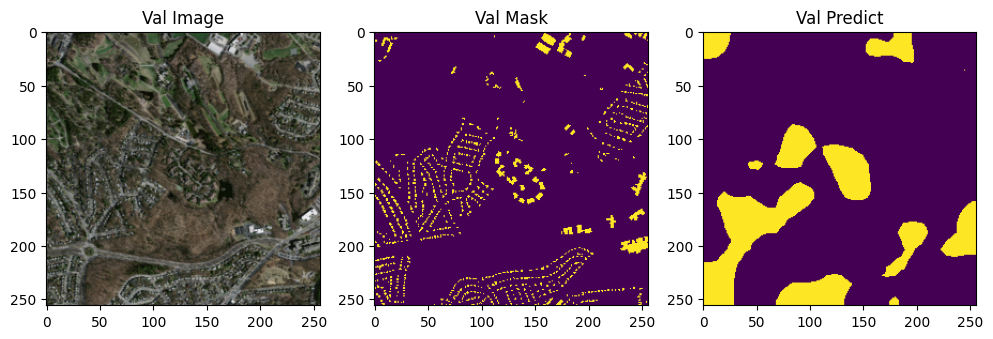

In [ ]:
import os
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision
import matplotlib.pyplot as plt

# ==== DATASET LOADER ====
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

class SegmentationDataset(Dataset):
    def __init__(self, img_dir, mask_dir=None, size=(256,256)):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.size = size
        self.imgs = sorted([f for f in os.listdir(img_dir) if f.lower().endswith(('.png','.jpg','.jpeg'))])
        self.masks = sorted([f for f in os.listdir(mask_dir) if f.lower().endswith(('.png','.jpg','.jpeg'))]) if mask_dir else None
        self.img_tf = transforms.Compose([
            transforms.Resize(self.size),
            transforms.ToTensor(),
            transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
        ])
    def __len__(self):
        return len(self.imgs)
    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.img_dir, self.imgs[idx])).convert('RGB')
        img = self.img_tf(img)
        if self.masks:
            mask = Image.open(os.path.join(self.mask_dir, self.masks[idx])).convert('L')
            mask = mask.resize(self.size, Image.NEAREST)
            mask = torch.from_numpy((np.array(mask) > 127).astype(np.uint8)).long()
            return img, mask
        else:
            return img

# ==== Supervised DeepLabV3+ ====
class SimpleDeepLab(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.backbone = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True)
        self.backbone.classifier[4] = nn.Conv2d(256, num_classes, 1)
    def forward(self, x):
        return self.backbone(x)['out']

# ==== Dice Loss ====
def dice_loss(pred, target, smooth=1.):
    pred = torch.softmax(pred, dim=1)[:,1]
    target = (target == 1).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    return 1 - ((2. * intersection + smooth) / (union + smooth))

# ==== Train supervised ====
def train_supervised(model, loader, optimizer, device, num_epochs=10):
    # Tính class weight tự động
    num_fg, num_bg = 0, 0
    for i in range(len(loader.dataset)):
        _, mask = loader.dataset[i]
        num_fg += (mask==1).sum().item()
        num_bg += (mask==0).sum().item()
    weight_bg = 1.0
    weight_fg = num_bg / (num_fg + 1e-8) if num_fg > 0 else 1.0
    weight_fg = min(weight_fg, 10.0)
    class_weights = torch.tensor([weight_bg, weight_fg]).to(device)
    print(f"== Class weights for loss: bg={weight_bg:.2f}, fg={weight_fg:.2f}")
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    model = model.to(device)
    for epoch in range(num_epochs):
        model.train()
        for imgs, masks in loader:
            imgs, masks = imgs.to(device), masks.to(device)
            output = model(imgs)
            output_up = nn.functional.interpolate(output, size=masks.shape[-2:], mode='bilinear', align_corners=False)
            ce_loss = criterion(output_up, masks)
            d_loss = dice_loss(output_up, masks)
            loss = 0.5 * ce_loss + 0.5 * d_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}/{num_epochs}: loss={loss.item():.4f}")
    print("Training Done!")

# ==== Visualize ====
def visualize_predict(model, ds, device, title=''):
    model.eval()
    with torch.no_grad():
        img, mask = ds[0]
        img_vis = img * torch.tensor(IMAGENET_STD).view(3,1,1) + torch.tensor(IMAGENET_MEAN).view(3,1,1)
        img_vis = (img_vis * 255).clip(0,255).byte().permute(1,2,0).cpu().numpy()
        out = model(img.unsqueeze(0).to(device))
        out_up = nn.functional.interpolate(out, size=mask.shape[-2:], mode='bilinear', align_corners=False)
        mean_pred = torch.softmax(out_up, dim=1)
        pred_mask = torch.argmax(mean_pred, dim=1)[0].cpu().numpy()
        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1); plt.imshow(img_vis); plt.title(f'{title} Image')
        plt.subplot(1,3,2); plt.imshow(mask.cpu()); plt.title(f'{title} Mask')
        plt.subplot(1,3,3); plt.imshow(pred_mask); plt.title(f'{title} Predict')
        plt.show()

# ==== MAIN ====
if __name__ == "__main__":
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    num_classes = 2
    batch_size = 4

    train_img = 'img_test_ver2/img_test_ver2/train_have_label'
    train_mask = 'img_test_ver2/img_test_ver2/train_label_using'
    val_img = 'img_test_ver2/img_test_ver2/val'
    val_mask = 'img_test_ver2/img_test_ver2/val_labels'

    ds_l = SegmentationDataset(train_img, train_mask, size=(256,256))
    ds_val = SegmentationDataset(val_img, val_mask, size=(256,256))

    loader_l = DataLoader(ds_l, batch_size=batch_size, shuffle=True, drop_last=True)
    loader_val = DataLoader(ds_val, batch_size=batch_size, shuffle=False)

    model = SimpleDeepLab(num_classes=num_classes)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    train_supervised(model, loader_l, optimizer, device, num_epochs=10)

    print("\n== Visualize kết quả trên ảnh TRAIN ==")
    visualize_predict(model, ds_l, device, title='Train')
    print("\n== Visualize kết quả trên ảnh VAL ==")
    visualize_predict(model, ds_val, device, title='Val')
